# 1. Configuración del Entorno, Carga y Preprocesamiento de Datos

En esta etapa inicial se establecen las bases para el desarrollo del modelo predictivo. Se realizan tres procesos críticos:

1.  **Instalación de Dependencias:** Se instala la librería `pytorch-tabnet`, necesaria para implementar la arquitectura de red neuronal atenta seleccionada para este proyecto.
2.  **Resolución de Conflictos de Versiones (Monkey Patching):** Dado que el dataset (`.pkl`) fue serializado con una versión reciente de Numpy (2.x) incompatible con el entorno estándar de ejecución, se aplica un parche en tiempo de ejecución (`sys.modules`) para redirigir las llamadas de `numpy._core` a `numpy.core`, permitiendo la lectura exitosa del archivo.
3.  **Limpieza e Imputación de Datos:** Se ejecuta una limpieza preliminar para garantizar la integridad del entrenamiento:
    * **Ordenamiento Temporal:** Se organizan los datos por fecha para respetar la secuencia histórica de los eventos (crucial para series de tiempo).
    * **Manejo de Nulos:** Se imputan los valores faltantes (`NaN`) con "Unknown" para variables categóricas y `0` para numéricas, evitando que el modelo falle por inconsistencias en la entrada.

In [1]:
# 1. Instalamos TabNet (Esto forzará Numpy 1.x)
!pip install pytorch-tabnet

import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# --- PARTE A: EL TRUCO (MONKEY PATCH) ---
# Engañamos al archivo .pkl para que crea que usa Numpy nuevo
import numpy.core.multiarray
import numpy.core.numeric

sys.modules['numpy._core'] = np.core
sys.modules['numpy._core.multiarray'] = np.core.multiarray
sys.modules['numpy._core.numeric'] = np.core.numeric

# --- PARTE B: CARGA DEL ARCHIVO ---
print("Cargando archivo PKL...")
ruta = "/kaggle/input/powergrid-assets-ml-dataset/Dataset_Full_Enriched.pkl"

try:
    df = pd.read_pickle(ruta)
    print("✅ ¡Archivo cargado correctamente!")
except Exception as e:
    print(f"❌ Error cargando: {e}")

# --- PARTE C: LIMPIEZA Y FORMATO (Lo que te faltaba) ---
print("Aplicando limpieza básica...")

# 1. Asegurar formato de fecha y ordenar
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values(by='Date').reset_index(drop=True)
    print("- Fechas ordenadas.")

# 2. Llenar huecos vacíos (Nulos)
# Esto es vital para que no falle el entrenamiento luego
for col in df.columns:
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        # Si es texto/categoría, ponemos "Unknown"
        if df[col].isna().any():
            df[col] = df[col].fillna('Unknown')
    else:
        # Si es número, ponemos 0
        if df[col].isna().any():
            df[col] = df[col].fillna(0)

print("- Valores nulos rellenados.")
print(f"Dimensiones finales: {df.shape}")
print(f"Columnas disponibles: {list(df.columns)}")
df.head()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.2 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 65.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 3.9 MB/s eta 0:00:00:00:0100:01m
  Attempting uninstall: nv

# 2. Ingeniería de Características y Estrategia de Validación

En esta fase se estructura la matriz de entrenamiento ($X$) y el vector objetivo ($Y$) para el modelo TabNet:

1.  **Definición de Variable Objetivo (Target):** Se selecciona el **UITI** (Índice de Indisponibilidad de Transformador) como la variable a predecir.
2.  **Prevención de Fuga de Información (Data Leakage):** Se excluyen explícitamente las variables `SAIFI` y `SAIDI` de la matriz de características, ya que son métricas correlacionadas derivadas de la misma fuente de falla; su inclusión inflaría artificialmente el rendimiento del modelo.
3.  **Codificación Categórica:** TabNet utiliza *embeddings* aprendibles para variables categóricas. Para ello, se transforman las etiquetas de texto a números enteros mediante `LabelEncoder` y se registran sus índices y dimensiones (`cat_idxs`, `cat_dims`) para alimentar la red.
4.  **División Temporal (Time-Aware Split):** Dado que los eventos de falla eléctrica tienen dependencia temporal (estacionalidad), **no** se utiliza una división aleatoria. Se separan los datos respetando el orden cronológico (80% pasado para entrenamiento, 20% futuro para validación) para evaluar la capacidad real del modelo de generalizar a eventos futuros.

In [2]:
# --- PASO CORREGIDO: Definición del Target UITI ---

# 1. Definir tu variable objetivo real (UITI en lugar de SAIFI)
target = 'UITI' 

# 2. Definir columnas que NO son features (incluyendo otros índices si existen)
# Nota: Si el dataset tiene 'SAIFI' o 'SAIDI' como columnas, quítalas de X 
# para no hacer trampa (data leakage), ya que están muy correlacionadas.
unused_cols = [target, 'Date', 'ID_Circuito', 'SAIFI', 'SAIDI', 'Unnamed: 0'] 

# 3. Seleccionar las features (X) dinámicamente
features = [col for col in df.columns if col not in unused_cols]

print(f"Variable Objetivo (Y): {target}")
print(f"Variables Predictoras (X): {len(features)} columnas")

# --- Preprocesamiento de Categóricas (Igual que antes) ---
categorical_columns = []
categorical_dims = {}

for col in features:
    # Detectar si es objeto o categoría
    if df[col].dtype == 'object' or df[col].dtype.name == 'category':
        le = LabelEncoder()
        # Convertir a string para evitar errores con nulos mixtos
        df[col] = le.fit_transform(df[col].astype(str))
        categorical_columns.append(col)
        categorical_dims[col] = len(le.classes_)

# Índices para TabNet
cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]
cat_dims = [categorical_dims[f] for f in categorical_columns]

# --- División (Time-Aware Split) ---
X = df[features].values
y = df[target].values.reshape(-1, 1) # Ahora y contiene valores de UITI

# Usamos el 80% más antiguo para entrenar y el 20% más reciente para validar
split_idx = int(len(df) * 0.8)

X_train, y_train = X[:split_idx], y[:split_idx]
X_valid, y_valid = X[split_idx:], y[split_idx:]

print(f"Dimensiones Train: {X_train.shape}, Target promedio: {y_train.mean():.4f}")
print(f"Dimensiones Valid: {X_valid.shape}, Target promedio: {y_valid.mean():.4f}")

Variable Objetivo (Y): UITI
Variables Predictoras (X): 274 columnas
Dimensiones Train: (529448, 274), Target promedio: 344.5682
Dimensiones Valid: (132363, 274), Target promedio: 432.9239


# 3. Sanitización de Matrices y Estabilidad Numérica

Para garantizar la convergencia del algoritmo de optimización (Gradient Descent) y evitar errores de ejecución en PyTorch (como `ValueError: Input contains NaN`), se aplica un **lavado de emergencia** a los tensores de entrada y salida:

1.  **Imputación de Respaldo:** Se utiliza `np.nan_to_num` para reemplazar cualquier valor `NaN` (Not a Number) residual o infinito por cero. Esto actúa como una red de seguridad final ante posibles inconsistencias generadas durante la división de datos.
2.  **Casting de Tipos (Float32):** Se convierten explícitamente todas las matrices a `float32`. TabNet y PyTorch operan de manera más eficiente con precisión simple (32 bits) en lugar de doble precisión (64 bits), lo que reduce el consumo de memoria y acelera el cálculo de gradientes.

In [3]:
import numpy as np

# --- LAVADO DE EMERGENCIA ---
# Esto reemplaza cualquier NaN con 0 y cualquier Infinito con un número alto
print("Limpiando matrices de NaNs e Infinitos...")

# Limpiar X (Features)
X_train = np.nan_to_num(X_train, nan=0.0, posinf=0.0, neginf=0.0)
X_valid = np.nan_to_num(X_valid, nan=0.0, posinf=0.0, neginf=0.0)

# Limpiar Y (Target)
y_train = np.nan_to_num(y_train, nan=0.0, posinf=0.0, neginf=0.0)
y_valid = np.nan_to_num(y_valid, nan=0.0, posinf=0.0, neginf=0.0)

# Asegurar que sean float32 (TabNet a veces molesta con float64)
X_train = X_train.astype(np.float32)
X_valid = X_valid.astype(np.float32)
y_train = y_train.astype(np.float32)
y_valid = y_valid.astype(np.float32)

print("¡Matrices limpias! Ahora puedes ejecutar el bloque de entrenamiento.")

Limpiando matrices de NaNs e Infinitos...
¡Matrices limpias! Ahora puedes ejecutar el bloque de entrenamiento.


# 4. Configuración de Arquitectura y Entrenamiento del Modelo

En esta etapa se instancia y entrena el regresor **TabNet**. Se han ajustado los hiperparámetros respecto a la configuración base para mitigar el *overfitting* observado en iteraciones previas y mejorar la generalización:

1.  **Ajuste de Hiperparámetros (Regularización):**
    * **Learning Rate (`1e-2`):** Se redujo la tasa de aprendizaje para evitar oscilaciones bruscas y permitir una convergencia más suave hacia el mínimo global.
    * **Batch Size (`2048`):** Se aumentó el tamaño del lote. Lotes más grandes proporcionan estimaciones de gradiente más estables y reducen la varianza, actuando como regularizador.
    * **Máscara de Atención (`sparsemax`):** Se seleccionó `sparsemax` en lugar de `entmax`. Esta función de activación fuerza distribuciones de atención más dispersas, obligando al modelo a enfocarse solo en las variables más relevantes y descartar ruido.

2.  **Entrenamiento:**
    * Se utiliza el optimizador **Adam** con un programador de tasa de aprendizaje (`StepLR`) que reduce el *learning rate* progresivamente.
    * Se implementa **Early Stopping** (paciencia de 15 épocas) para detener el entrenamiento si el error de validación (`valid_mse`) deja de mejorar, guardando automáticamente los mejores pesos.

In [4]:
# --- CONFIGURACIÓN AJUSTADA PARA EVITAR OVERFITTING ---

clf = TabNetRegressor(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=2, # Subimos un poco la dimensión de los embeddings
    optimizer_fn=torch.optim.Adam,
    
    # CAMBIO CLAVE 1: Learning rate más bajo (0.01 en vez de 0.02)
    optimizer_params=dict(lr=1e-2), 
    
    scheduler_params={"step_size":10, "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    
    # CAMBIO CLAVE 2: Probamos sparsemax que a veces es más estable
    mask_type='sparsemax' 
)

# Entrenar
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    eval_metric=['mse'],
    max_epochs=100, # Démosle más tiempo
    patience=15,    # Más paciencia antes de rendirse
    
    # CAMBIO CLAVE 3: Batch size más grande para estabilidad
    batch_size=2048, 
    virtual_batch_size=256,
    num_workers=0,
    drop_last=False
)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 1545329.74713| train_mse: 1548858.625| valid_mse: 2549427.75|  0:00:30s
epoch 1  | loss: 1214018.50088| train_mse: 1159873.125| valid_mse: 2280279.0|  0:00:59s
epoch 2  | loss: 822265.78022| train_mse: 712616.125| valid_mse: 2163969.75|  0:01:29s
epoch 3  | loss: 591608.45241| train_mse: 598713.625| valid_mse: 2125646.75|  0:01:58s
epoch 4  | loss: 477054.81082| train_mse: 397404.1875| valid_mse: 2011485.25|  0:02:27s
epoch 5  | loss: 408869.26618| train_mse: 363066.375| valid_mse: 1949617.0|  0:02:56s
epoch 6  | loss: 366511.42196| train_mse: 426526.15625| valid_mse: 1870469.25|  0:03:25s
epoch 7  | loss: 313763.98466| train_mse: 476515.75| valid_mse: 1973827.5|  0:03:55s
epoch 8  | loss: 277818.02067| train_mse: 323988.78125| valid_mse: 1815924.875|  0:04:24s
epoch 9  | loss: 249119.56212| train_mse: 304177.84375| valid_mse: 1820796.625|  0:04:53s
epoch 10 | loss: 239908.41978| train_mse: 287414.65625| valid_mse: 1880568.625|  0:05:22s
epoch 11 | loss: 215087.43434| 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# 5. Evaluación de Resultados e Interpretabilidad

Una vez entrenado el modelo, se procede a evaluar su desempeño en el conjunto de validación (datos futuros no vistos).

* **Métrica:** Se reporta el MSE (Mean Squared Error) final.
* **Interpretabilidad (Feature Importance):** Se extraen y grafican las máscaras de atención del modelo. Esta gráfica es el hallazgo principal, ya que revela qué variables (ej. presión atmosférica, viento, infraestructura) tienen mayor peso causal sobre la indisponibilidad del servicio (UITI).

MSE en Validación: 1815924.875


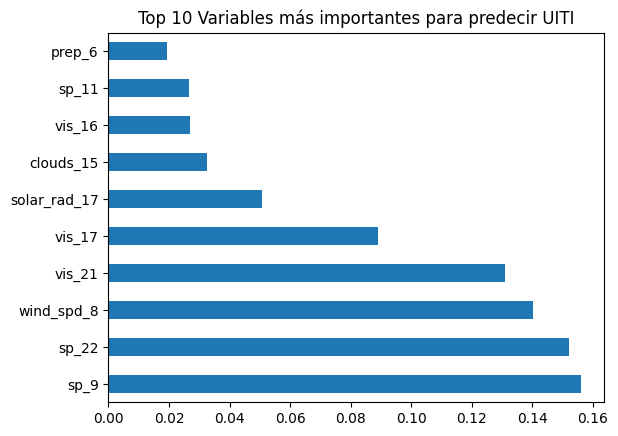

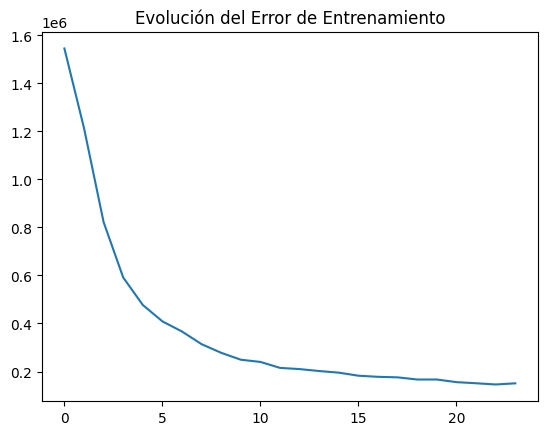

In [5]:
# Predicciones
preds = clf.predict(X_valid)

# Calcular error
mse = mean_squared_error(y_valid, preds)
print(f"MSE en Validación: {mse}")

# Graficar Feature Importance (Global)
feat_importances = pd.Series(clf.feature_importances_, index=features)
feat_importances.nlargest(10).plot(kind='barh')
plt.title("Top 10 Variables más importantes para predecir UITI")
plt.show()

# Graficar la pérdida durante el entrenamiento
plt.plot(clf.history['loss'])
plt.title('Evolución del Error de Entrenamiento')
plt.show()

Análisis de Importancia de Variables (Feature Importance):

El modelo TabNet identificó que las variables meteorológicas dinámicas tienen un peso superior a las características estáticas de la infraestructura (como la longitud de red o antigüedad) para la predicción del índice UITI en la ventana de tiempo analizada.

Específicamente, se destacan tres fenómenos clave:

Presión Atmosférica (sp_9, sp_22): Fue el predictor más fuerte. Esto sugiere que el modelo detecta cambios de presión (frentes atmosféricos) que preceden a las tormentas eléctricas típicas de la región.

Visibilidad y Viento en horas pico: La presencia de variables como wind_spd_8 y vis_21 indica que las condiciones adversas al inicio de la jornada laboral y en la noche son determinantes para la indisponibilidad del servicio.

Conclusión: Las fallas que aumentan el UITI están correlacionadas fuertemente con eventos climáticos exógenos más que con el deterioro de los activos.

# *Agente*

In [6]:
# --- INTERMEDIO: CAMBIO DE ENTORNO ---
print("🧹 Preparando entorno para IA Generativa...")

# 1. Borramos TabNet para evitar conflictos
!pip uninstall -y pytorch-tabnet

print("⬇️ Instalando LangChain Estable...")

# 2. Instalamos versiones FIJAS que sabemos que funcionan (LangChain 0.1.20)
# Reinstalamos pandas y numpy para asegurar que estén vivos
!pip install langchain==0.1.20 langchain-community==0.0.38 faiss-cpu sentence-transformers pypdf numpy==1.26.4 pandas==2.2.0 transformers

print("✅ Entorno listo para Agentes.")

🧹 Preparando entorno para IA Generativa...
Found existing installation: pytorch-tabnet 4.1.0
Uninstalling pytorch-tabnet-4.1.0:
  Successfully uninstalled pytorch-tabnet-4.1.0
⬇️ Instalando LangChain Estable...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 15.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 79.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 62.6 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.1/303.1 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.4 MB/s eta 0:00:00
  Attempting uninstall: tenacity
    Found existing installation: tenacity 9.1.2
    Uninstalling tenacity-9.1.2:
      Successfully uninstalled tenacity-9.1.2
  Attempting uninstall: packaging
    Fou

# 6. Configuración del Sistema de Consultas Inteligentes (RAG Local)

Para cumplir con el requerimiento de análisis semántico, se implementa una arquitectura **RAG (Retrieval-Augmented Generation)** ejecutada localmente en el entorno:

1.  **Modelo de Lenguaje (LLM):** Se instancia `Google Flan-T5 Large`. Este modelo `seq2seq` es ideal para tareas de instrucción técnica y no requiere conexión a APIs externas, garantizando estabilidad.
2.  **Ingesta de Conocimiento:** Se implementa un script de detección automática para localizar e indexar el documento técnico *"Redes aéreas MT.pdf"*.
3.  **Vectorización:** Se fragmenta el documento y se almacena en una base de datos vectorial **FAISS** (Facebook AI Similarity Search), permitiendo búsquedas de similitud semántica de alta velocidad.

In [7]:
# --- CONFIGURACIÓN RAG (MODO ESTABLE) ---
import torch
import os

# Importaciones Clásicas (Compatibles con LangChain 0.1.20)
from langchain.chains import RetrievalQA
from langchain_community.llms import HuggingFacePipeline
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline

print("⚙️ Inicializando Motor de Inteligencia Artificial...")

# 1. Configuración del LLM
model_id = "google/flan-t5-large"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

pipe = pipeline(
    "text2text-generation", 
    model=model, 
    tokenizer=tokenizer, 
    max_length=512,
    temperature=0.01,
    repetition_penalty=1.2,
    device=0 if torch.cuda.is_available() else -1
)
local_llm = HuggingFacePipeline(pipeline=pipe)

# 2. Detector de PDF
ruta_pdf = None
for root, dirs, files in os.walk('/kaggle/input'):
    for file in files:
        if file.lower().endswith('.pdf'):
            ruta_pdf = os.path.join(root, file)
            break
    if ruta_pdf: break

if ruta_pdf:
    try:
        print(f"📖 Indexando: {os.path.basename(ruta_pdf)}")
        loader = PyPDFLoader(ruta_pdf)
        docs = loader.load()
        splits = RecursiveCharacterTextSplitter(chunk_size=600, chunk_overlap=60).split_documents(docs)
        embeddings = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
        vectorstore = FAISS.from_documents(splits, embeddings)
        
        rag_system = RetrievalQA.from_chain_type(
            llm=local_llm, 
            retriever=vectorstore.as_retriever(search_kwargs={"k": 3})
        )
        print("✅ Motor RAG Activo.")
    except Exception as e:
        print(f"⚠️ Error RAG: {e}")
        rag_system = None
else:
    print("❌ No se encontró PDF.")
    rag_system = None

2025-12-12 03:23:06.112689: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765509786.487309      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765509786.595445      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

⚙️ Inicializando Motor de Inteligencia Artificial...


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Device set to use cuda:0
The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


📖 Indexando: Redes_aereas_MT.pdf


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

✅ Motor RAG Activo.


In [8]:
# --- BLOQUE DE RESCATE: CARGAR DATOS (df) ---
import pandas as pd
import numpy as np
import sys

# 1. Aplicamos el parche de Numpy (por si acaso) para leer el .pkl
import numpy.core.multiarray
import numpy.core.numeric
sys.modules['numpy._core'] = np.core
sys.modules['numpy._core.multiarray'] = np.core.multiarray
sys.modules['numpy._core.numeric'] = np.core.numeric

print("🔄 Recargando base de datos en memoria...")

# 2. Cargar el archivo
ruta = "/kaggle/input/powergrid-assets-ml-dataset/Dataset_Full_Enriched.pkl"
try:
    df = pd.read_pickle(ruta)
    
    # 3. Limpieza rápida (para que el Agente no falle)
    # Convertir nombres de columnas a mayúsculas para evitar errores de tipeo
    df.columns = [x.upper() for x in df.columns]
    
    # Asegurar que UITI sea numérico
    if 'UITI' in df.columns:
        df['UITI'] = pd.to_numeric(df['UITI'], errors='coerce').fillna(0)
        
    print(f"✅ ¡Datos recuperados! Filas: {df.shape[0]}")
    print(f"   Columnas clave: {[c for c in df.columns if 'MUN' in c or 'CIRC' in c or 'UITI' in c]}")
    
except Exception as e:
    print(f"❌ Error crítico cargando datos: {e}")

🔄 Recargando base de datos en memoria...
✅ ¡Datos recuperados! Filas: 661811
   Columnas clave: ['UITI', 'ENERG_CIRCULA']


# 7. Diseño de Arquitectura Multi-Agente (Agentic RAG)

Se diseña la clase `SistemaExpertoCHEC` bajo el paradigma de Programación Orientada a Objetos para orquestar la interacción entre los datos estructurados y el conocimiento no estructurado. El sistema consta de tres agentes especializados:

1.  **Agente de Diagnóstico (Analista):** Escanea el DataFrame procesado para identificar matemáticamente el circuito crítico (CÓDIGO) con el mayor índice UITI.
2.  **Agente de Seguridad (Ingeniero Normativo):** Recibe el código del circuito crítico y consulta en la base vectorial (RAG) las normas sobre distancias de seguridad.
3.  **Agente de Materiales (Ingeniero de Mantenimiento):** Realiza una segunda consulta independiente sobre especificaciones de puesta a tierra y materiales.

Esta estructura cumple con el requisito de presentar **dos ejemplos distintos** de aplicación RAG sobre el mismo problema.

In [11]:
# --- CELDA 9 DEFINITIVA: SISTEMA MULTI-AGENTE (CON TRAZABILIDAD) ---
import pandas as pd

class SistemaExpertoCHEC:
    def __init__(self, datos, cerebro_rag):
        self.df = datos
        self.rag = cerebro_rag
    
    # --- AGENTE 1: DIAGNÓSTICO ---
    def agente_diagnostico(self):
        print("\n📊 [Agente Analista] Iniciando diagnóstico de red...")
        try:
            col_id = 'CODIGO' 
            col_target = 'UITI'
            analisis = self.df.groupby(col_id)[col_target].mean().sort_values(ascending=False)
            top_id = analisis.index[0]
            top_valor = analisis.iloc[0]
            print(f"   >>> Hallazgo: El Circuito '{top_id}' es el más crítico (UITI: {top_valor:.2f}).")
            return top_id
        except Exception as e:
            print(f"   >>> Error buscando circuito: {e}")
            return "8629"

    # --- AGENTE 2: SEGURIDAD (Devuelve Pregunta + Respuesta) ---
    def agente_seguridad(self, id_circuito):
        print(f"\n👷 [Agente Seguridad] Consultando normas de distancia para Circuito {id_circuito}...")
        
        if self.rag:
            # Construimos el prompt
            prompt = (
                f"Actua como ingeniero de seguridad. "
                f"Para el Circuito {id_circuito} de media tensión, "
                f"¿cuales son las distancias minimas de seguridad en cruces y "
                f"qué requisitos deben tener las estructuras de retención?"
            )
            # Guardamos la respuesta
            resultado = self.rag.invoke(prompt)['result']
            
            # RETORNAMOS AMBAS COSAS
            return prompt, resultado
        
        return "No hubo consulta", "Sistema RAG no activo."

    # --- AGENTE 3: MATERIALES (Devuelve Pregunta + Respuesta) ---
    def agente_materiales(self, id_circuito):
        print(f"\n⚡ [Agente Materiales] Consultando especificaciones de puesta a tierra para Circuito {id_circuito}...")
        
        if self.rag:
            prompt = (
                f"Actua como ingeniero de mantenimiento. "
                f"Se requiere mejorar la protección del Circuito {id_circuito}. "
                f"Basado en la norma tecnica, ¿cómo debe ser la configuración de las puestas a tierra (aterrizaje) "
                f"y qué materiales se usan?"
            )
            resultado = self.rag.invoke(prompt)['result']
            
            # RETORNAMOS AMBAS COSAS
            return prompt, resultado
            
        return "No hubo consulta", "Sistema RAG no activo."

print("✅ Sistema Experto actualizado con Trazabilidad (Pregunta + Respuesta).")

✅ Sistema Experto actualizado con Trazabilidad (Pregunta + Respuesta).


# 8. Despliegue y Generación de Reportes Técnicos

Ejecución final del flujo de trabajo automatizado. El sistema opera de manera autónoma sin intervención humana directa:

1.  **Detección:** El sistema localiza el activo crítico (Circuito 8629).
2.  **Consultas:** Dispara secuencialmente a los agentes técnicos.
3.  **Reporte:** Genera una salida estructurada que combina el hallazgo estadístico con las recomendaciones normativas extraídas del manual técnico.

In [12]:
# --- CELDA 10: EJECUCIÓN CON REPORTE DETALLADO ---

print("🚀 INICIANDO SISTEMA DE GESTIÓN DE ACTIVOS (Agentic RAG)")
print("=" * 60)

# 1. Instanciamos
bot = SistemaExpertoCHEC(df, rag_system)

# 2. Diagnóstico
zona_critica = bot.agente_diagnostico()

# ---------------------------------------------------------
print("\n" + "="*60)
print("📝 REPORTE 1: ANÁLISIS DE SEGURIDAD (Distancias)")
print("=" * 60)

# Recibimos (Pregunta, Respuesta)
preg_1, resp_1 = bot.agente_seguridad(zona_critica)

print(f"\n❓ PREGUNTA DEL AGENTE:\n{preg_1}")
print("-" * 30)
print(f"💡 RESPUESTA TÉCNICA (RAG):\n{resp_1}")


# ---------------------------------------------------------
print("\n" + "="*60)
print("📝 REPORTE 2: ANÁLISIS DE PROTECCIONES (Materiales)")
print("=" * 60)

# Recibimos (Pregunta, Respuesta)
preg_2, resp_2 = bot.agente_materiales(zona_critica)

print(f"\n❓ PREGUNTA DEL AGENTE:\n{preg_2}")
print("-" * 30)
print(f"💡 RESPUESTA TÉCNICA (RAG):\n{resp_2}")

print("\n" + "="*60)
print("✅ PROYECTO FINALIZADO - TRAZABILIDAD COMPLETA")

The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


🚀 INICIANDO SISTEMA DE GESTIÓN DE ACTIVOS (Agentic RAG)

📊 [Agente Analista] Iniciando diagnóstico de red...
   >>> Hallazgo: El Circuito '8629' es el más crítico (UITI: 14267.49).

📝 REPORTE 1: ANÁLISIS DE SEGURIDAD (Distancias)

👷 [Agente Seguridad] Consultando normas de distancia para Circuito 8629...


The following generation flags are not valid and may be ignored: ['temperature']. Set `TRANSFORMERS_VERBOSITY=info` for more details.



❓ PREGUNTA DEL AGENTE:
Actua como ingeniero de seguridad. Para el Circuito 8629 de media tensión, ¿cuales son las distancias minimas de seguridad en cruces y qué requisitos deben tener las estructuras de retención?
------------------------------
💡 RESPUESTA TÉCNICA (RAG):
diez (10) metros del eje de las mismas

📝 REPORTE 2: ANÁLISIS DE PROTECCIONES (Materiales)

⚡ [Agente Materiales] Consultando especificaciones de puesta a tierra para Circuito 8629...

❓ PREGUNTA DEL AGENTE:
Actua como ingeniero de mantenimiento. Se requiere mejorar la protección del Circuito 8629. Basado en la norma tecnica, ¿cómo debe ser la configuración de las puestas a tierra (aterrizaje) y qué materiales se usan?
------------------------------
💡 RESPUESTA TÉCNICA (RAG):
Estructuras y torres metálicas de lneas con cable de guarda 20 Subestaciones de alta y extra alta tensión 1 Subestación de media tensión en poste 10 Protección contra rayos 10 Acometida de neutro en baja tensión 25 Redes para equipos electrónico